In [4]:
from kpsn.util.simple_density import PointCloudDensity, cloud_kl, cloud_js
import matplotlib.pyplot as plt
import joblib as jl
import numpy as np

In [2]:
precomputed = jl.load('../../generative/results/lra_animal/blsplit/pl7-ml6-mop0/reconst_divs.jl')
# Steps at which reconstruction was computed
steps = precomputed['steps']
# Names of sessions to be projected onto reference sessions
nonref_sessions = precomputed['nonref_sessions']
# Names of reference sessions that bodies were projected onto
ref_sessions = precomputed['ref_sessions']
# Aligned keypoints for each session
# dict[session_name, np.array(n_frames, 38)]
keypts = precomputed['keypts']
# Keypoints from each session projected onto a reference session according to
# morph at a step of training
# nested_list<array> (step, ref_sess, nonref_sess, frame, 38)
reconst = precomputed['reconst']

In [5]:
K = 15
ref_clouds = {s: PointCloudDensity(k = K).fit(keypts[s]) for s in ref_sessions}

# JSDs between reference sessions
assert len(ref_sessions) == 2
ref_to_ref = cloud_js(ref_clouds[ref_sessions[0]], ref_clouds[ref_sessions[1]])

# JSDs between reference and non-reference sessions with/without morph
# unmorphed[i, j] = jsd(ref_sessions[i], nonref_sessions[j])
# unmorphed[l, i, j] = jsd(ref_sessions[i], morph_onto_ref[l, i](nonref_sessions[j]))
unmorphed = np.zeros([len(ref_sessions), len(nonref_sessions)])
morphed = np.zeros([len(steps), len(ref_sessions), len(nonref_sessions)])
for i, ref_sess in enumerate(ref_sessions):
    for j, nonref_sess in enumerate(nonref_sessions):
        print(f"Computing JSDs: {ref_sess} <-> {nonref_sess}")
        unmorphed[i, j] = cloud_js(
            ref_clouds[ref_sess],
            PointCloudDensity(k = K).fit(keypts[nonref_sess]))
        
        for l, step in enumerate(steps):
            morphed[l, i, j] = cloud_js(
                ref_clouds[ref_sess],
                PointCloudDensity(k = K).fit(reconst[l][i][j]))

Computing JSDs: 3wk_m0.0 <-> 3wk_m0.0
Computing JSDs: 3wk_m0.0 <-> 52wk-3wk_m0.0
Computing JSDs: 3wk_m0.0 <-> 3wk_m0.1
Computing JSDs: 3wk_m0.0 <-> 52wk-3wk_m0.1
Computing JSDs: 3wk_m0.1 <-> 3wk_m0.0
Computing JSDs: 3wk_m0.1 <-> 52wk-3wk_m0.0
Computing JSDs: 3wk_m0.1 <-> 3wk_m0.1
Computing JSDs: 3wk_m0.1 <-> 52wk-3wk_m0.1


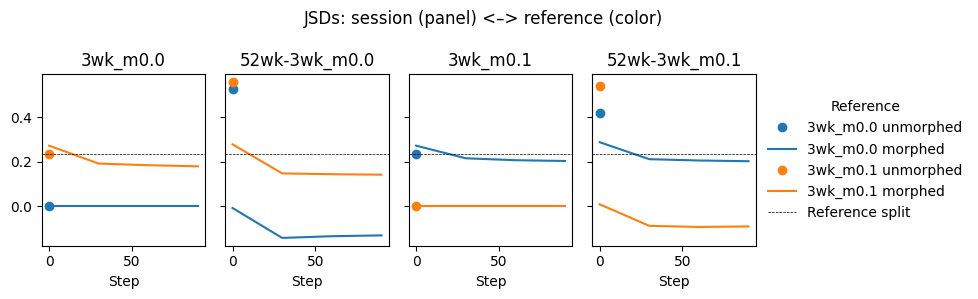

In [6]:

fig, ax = plt.subplots(1, len(nonref_sessions), figsize = (10, 3), sharex=True, sharey=True)
pal = ['C0', 'C1']
for j, nonref_sess in enumerate(nonref_sessions):
    for i, ref_sess in enumerate(ref_sessions):
        ax[j].plot(0, unmorphed[i, j], 'o', color = pal[i], label = f"{ref_sess} unmorphed")
        ax[j].plot(steps, morphed[:, i, j], color = pal[i], label = f"{ref_sess} morphed")
    ax[j].set_title(nonref_sess)
    ax[j].set_xlabel("Step")
    ax[j].axhline(ref_to_ref, ls = '--', color = 'k', lw = 0.5, label = "Reference split")
ax[-1].legend(bbox_to_anchor = (1, 0.5), loc = 'center left', frameon = False, title = "Reference")
fig.suptitle("JSDs: session (panel) <–> reference (color)")
plt.tight_layout()

In [9]:
# KL divergences between some of the distributions which are getting negative
# JSD
ref_sess_tests = ['3wk_m0.0', '3wk_m0.0', '3wk_m0.0', '3wk_m0.1']
nonref_sess_tests = ['3wk_m0.0', '3wk_m0.1', '52wk-3wk_m0.0', '52wk-3wk_m0.1']
step = 1
for ref_sess, nonref_sess in zip(ref_sess_tests, nonref_sess_tests):

    ref_ix = ref_sessions.index(ref_sess)
    nonref_ix = nonref_sessions.index(nonref_sess)
    
    calced_jsd = morphed[step, ref_ix, nonref_ix]
    print("Test:", ref_sess, nonref_sess, f"(jsd {calced_jsd})")

    cloud_a = PointCloudDensity(k = 15).fit(keypts[ref_sess])
    cloud_b = PointCloudDensity(k = 15).fit(reconst[step][ref_ix][nonref_ix])

    kl_ab = cloud_kl(cloud_a, cloud_b)
    kl_ba = cloud_kl(cloud_b, cloud_a)
    print('-> kls:', kl_ab, kl_ba)

Test: 3wk_m0.0 3wk_m0.0 (jsd -6.229393277054523e-13)
-> kls: 1.944131288294829e-09 -1.9441457266966844e-09
Test: 3wk_m0.0 3wk_m0.1 (jsd 0.21539200611119436)
-> kls: 7.032282201614167 11.331811540098219
Test: 3wk_m0.0 52wk-3wk_m0.0 (jsd -0.14313642992359854)
-> kls: -0.46714034578398556 1.7554229693424754
Test: 3wk_m0.1 52wk-3wk_m0.1 (jsd -0.08870790346733662)
-> kls: -0.4639293601127094 1.1834517775273028


In [10]:
# Attempt to reproduce negative JS/KL by shifting

test_offsets = np.linspace(0, 10, 5)
ref_sess = '3wk_m0.0'

cloud_a = PointCloudDensity(k = 15).fit(keypts[ref_sess])

for ofs in test_offsets:
    b_data = cloud_a._tree.data.copy() + ofs
    cloud_b = PointCloudDensity(k = 15).fit(b_data)

    kl_ab = cloud_kl(cloud_a, cloud_b)
    kl_ba = cloud_kl(cloud_b, cloud_a)
    jsd = cloud_js(cloud_a, cloud_b)

    print("Offset:", ofs)
    print("-> kls:", kl_ab, kl_ba)
    print("-> jsd:", jsd)


Offset: 0.0
-> kls: -0.0 -0.0
-> jsd: 0.0
Offset: 2.5
-> kls: 11.801535785780207 11.685698365294662
-> jsd: 0.6239251708072895
Offset: 5.0
-> kls: 26.660609766858965 27.21342805705722
-> jsd: 0.6921953091091175
Offset: 7.5
-> kls: 39.111889295943676 40.027762873679016
-> jsd: 0.6930812103051116
Offset: 10.0
-> kls: 49.28447916630242 50.26862963738193
-> jsd: 0.6931471115130714



>>> offset: 0.0


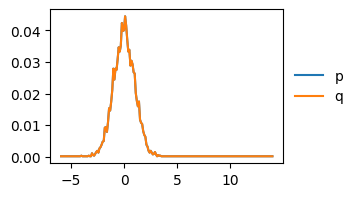

histogram
-> kls 0.0 0.0
-> jsd 0.0
cloud
-> kls:, kl(p|q) = -0.0, kl(q|p) = -0.0
-> jsd: 0.0

>>> offset: 2.5


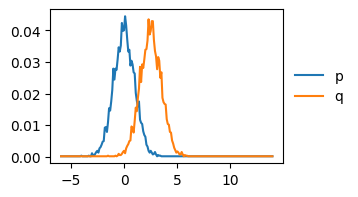

histogram
-> kls 2.528482519381064 2.5023222802596132
-> jsd 0.6454724685920613
cloud
-> kls:, kl(p|q) = 2.8530991396748586, kl(q|p) = 2.771939610940176
-> jsd: 0.4532109187669836

>>> offset: 5.0


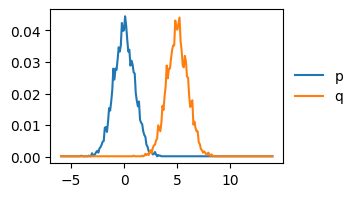

histogram
-> kls 4.580135131934135 4.588483164649645
-> jsd 0.7856137020642482
cloud
-> kls:, kl(p|q) = 5.9181918655190975, kl(q|p) = 5.830039776623157
-> jsd: 0.6754481231024105


In [11]:
# Compare measurements to scipy kl and jsd functions

from scipy import special 
from scipy.spatial import distance
test_offsets = np.linspace(0, 5, 3)
N = 5000; n_bin = 200; k = 15
a_data = np.random.randn(N)

bins = np.linspace(-6, 14, n_bin)
a_hist = np.histogram(a_data, bins = bins)[0] + 1
a_hist = a_hist / a_hist.sum()
cloud_a = PointCloudDensity(k = k).fit(a_data.reshape(-1, 1))

for ofs in test_offsets:

    b_data = a_data + ofs
    b_hist = np.histogram(b_data, bins = bins)[0] + 1
    b_hist = b_hist / b_hist.sum()
    print('\n>>> offset:', ofs)

    fig = plt.figure(figsize = (3, 2))
    plt.plot((bins[1:] + bins[:-1]) / 2, a_hist, 'C0', label = "p")
    plt.plot((bins[1:] + bins[:-1]) / 2, b_hist, 'C1', label = "q")
    plt.legend(bbox_to_anchor = (1, 0.5), loc = 'center left', frameon = False)
    plt.show()

    print("histogram")
    print("-> kls", special.rel_entr(a_hist, b_hist).sum(), special.rel_entr(b_hist, a_hist).sum())
    print("-> jsd", distance.jensenshannon(a_hist, b_hist))

    cloud_b = PointCloudDensity(k = k).fit(b_data.reshape(-1, 1))
    kl_ab = cloud_kl(cloud_a, cloud_b)
    kl_ba = cloud_kl(cloud_b, cloud_a)
    jsd = cloud_js(cloud_a, cloud_b)

    print("cloud")
    print(f"-> kls:, kl(p|q) = {kl_ab}, kl(q|p) = {kl_ba}")
    print("-> jsd:", jsd)